# __`scikit-learn`-style API__

In [1]:
import adelie as ad
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.datasets import load_diabetes
np.random.seed(42)

Scikit regression data for testing

In [2]:
data = load_diabetes()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, y_train.shape, X_test.shape,  y_test.shape

((353, 10), (353,), (89, 10), (89,))

/tmp/ipykernel_827669/76418139.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


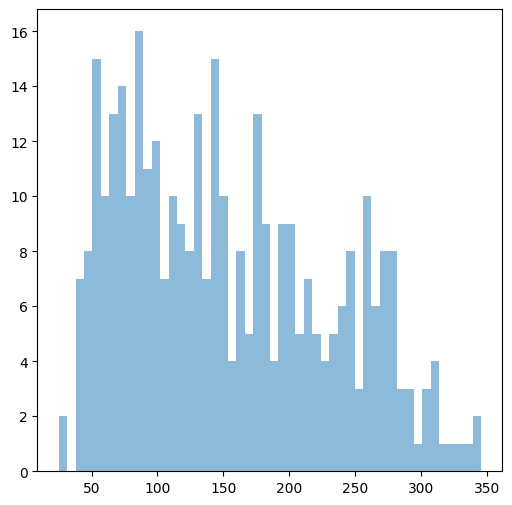

In [3]:
f, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.hist(y_train, bins=50, alpha=0.5, label='train')
f.show()

## __Lasso__

Instantiate a `GroupElasticNet` class 

In [4]:
lam_path = np.logspace(-10, 10, 100)
m0 = ad.GroupElasticNet(solver="grpnet")
m0.fit(X_train, y_train, lmda_path=lam_path)  # fit
yhatmat = m0.predict(
    X_test
)  # predict - produces a matrix of predictions where each row is the prediction vector for a given lambda
print(yhatmat.shape)

/home/alal/Desktop/forks/adelie/adelie/matrix.py:437: UserWarning: Detected matrix to be C-contiguous. Performance may improve with F-contiguous matrix.
  warnings.warn(
100%|██████████| 100/100 [00:00:00<00:00:00, 23502.40it/s] [dev:52.8%]


(100, 89)


Compute out-of-sample R-squared for each $\lambda$ value

Text(0.5, 1.0, 'Out of sample $R^2$ over $\\lambda$')

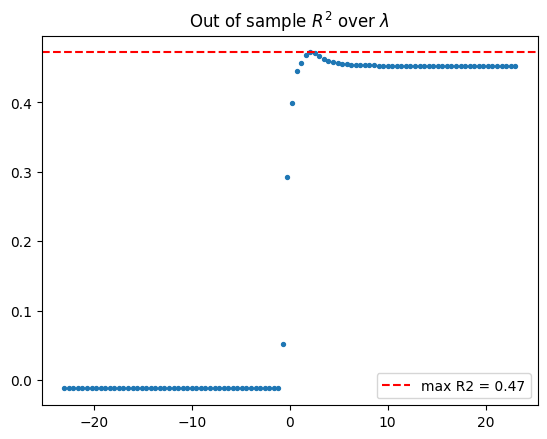

In [5]:
r2vec = np.apply_along_axis(lambda yhat: r2_score(y_test, yhat), axis=1, arr=yhatmat)
plt.scatter(np.log(lam_path), r2vec, s = 8)
plt.axhline(r2vec.max(), color="red", linestyle="--", label=f"max R2 = {r2vec.max():.2f}")
plt.legend()
plt.title(r"Out of sample $R^2$ over $\lambda$")

## __basic cross-validation : `cv_grpnet` solver__

when the model class is initalized with `cv_grpnet`, we select the best lambda by cross-validation and return the corresponding model.

In [6]:
m = ad.GroupElasticNet(solver="cv_grpnet")
m.fit(X_train, y_train, lmda_path_size=1_000, min_ratio=1e-3)

/home/alal/Desktop/forks/adelie/adelie/matrix.py:437: UserWarning: Detected matrix to be C-contiguous. Performance may improve with F-contiguous matrix.
  warnings.warn(
  0%|          | 0/1003 [00:00:00<?, ?it/s]

100%|██████████| 1/1 [00:00:00<00:00:00, 905.26it/s] [dev:52.6%] 


GroupElasticNet(solver='cv_grpnet')

With the `cv_grpnet` backend, calling predict automatically uses the model with the best lambda.

In [7]:
m.predict(X_test).shape

(89,)

The class also has a score method that computes r-squared. 

In [8]:
m.score(X_test, y_test)

0.45678584045740367